In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ===============================
# 1. KAGGLE DATASET PATHS - FIXED NESTED STRUCTURE
# ===============================
print("🔍 ACCESSING IMAGE DATASET...")
print("=" * 50)

# CORRECT PATH: The classes are in the nested folder
dataset_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

print(f"📁 Dataset Path: {dataset_path}")

# Verify the path exists and show the class folders
if os.path.exists(dataset_path):
    print(f"✅ Dataset found!")
    print(f"📊 CLASS FOLDERS:")
    
    classes = []
    total_images = 0
    
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            # Count image files
            image_files = [f for f in os.listdir(item_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.dcm'))]
            file_count = len(image_files)
            
            print(f"  📁 {item}/: {file_count} images")
            classes.append(item)
            total_images += file_count
    
    print(f"\n🎯 DATASET SUMMARY:")
    print(f"  📊 Total classes: {len(classes)}")
    print(f"  🖼️  Total images: {total_images}")
    print(f"  🏷️  Classes: {classes}")
    print(f"  ✅ Ready for training!")
    
else:
    print(f"❌ Path not found!")
    # Fallback to parent directory
    dataset_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone'
    classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
    print(f"Using fallback path: {dataset_path}")
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
        print(f"{class_name}: {num_images} images")
    else:
        print(f"Warning: {class_name} folder not found!")

2025-09-23 15:44:27.034258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758642267.370986      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758642267.465097      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
🔍 ACCESSING IMAGE DATASET...
📁 Dataset Path: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
✅ Dataset found!
📊 CLASS FOLDERS:
  📁 Cyst/: 3709 images
  📁 Tumor/: 2283 images
  📁 Stone/: 1377 images
  📁 Normal/: 5077 images

🎯 DATASET SUMMARY:
  📊 Total classes: 4
  🖼️  Total images: 12446
  🏷️  Classes: ['Cyst', 'Tumor', 'Stone', 'Normal']
  ✅ Ready for training!
Cyst: 3709 images
Tumor: 2283 images
Stone: 1377 images
Normal: 5077 images


In [2]:
# 2. OPTIMIZED HYPERPARAMETERS FOR THIS DATASET
# ===============================
IMG_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 16  # Good for this dataset size
EPOCHS = 30  # Sufficient for this dataset
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
VALIDATION_SPLIT = 0.2

# Based on dataset analysis, this dataset has:
# - Cyst: ~3000+ images
# - Normal: ~5000+ images  
# - Stone: ~1000+ images
# - Tumor: ~2000+ images
# Total: ~12,000+ images - excellent size for deep learning

# ===============================
# 3. ENHANCED DATA PREPROCESSING & AUGMENTATION
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"\n📊 NAZMUL'S CT KIDNEY DATASET LOADED")
print(f"🔗 Source: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")
print(f"📁 Dataset Path: {dataset_path}")
print(f"🏷️  Classes: {classes}")
print(f"📈 Class Distribution:")
print(f"📊 Class Distribution:")
for class_name, class_idx in train_generator.class_indices.items():
    count = list(train_generator.classes).count(class_idx)
    print(f"  {class_name}: {count} samples")

print(f"\n📈 Training Setup:")
print(f"  🔹 Training samples: {train_generator.samples}")
print(f"  🔹 Validation samples: {validation_generator.samples}")
print(f"  🔹 Batch size: {BATCH_SIZE}")
print(f"  🔹 Image size: {IMG_SIZE}")
print(f"  🔹 Total epochs planned: {EPOCHS}")

# Calculate total images from generators
total_training_images = train_generator.samples
total_validation_images = validation_generator.samples
total_images = total_training_images + total_validation_images
    
print(f"\n🎯 Expected High Accuracy Factors:")
print(f"  ✅ Large dataset size ({total_images} total images)")
print(f"  ✅ Balanced classes (reasonable distribution)")
print(f"  ✅ Medical CT scans (clear structural differences)")
print(f"  ✅ VGG16 transfer learning (proven for medical imaging)")


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.

📊 NAZMUL'S CT KIDNEY DATASET LOADED
🔗 Source: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
📁 Dataset Path: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
🏷️  Classes: ['Cyst', 'Tumor', 'Stone', 'Normal']
📈 Class Distribution:
📊 Class Distribution:
  Cyst: 2968 samples
  Normal: 4062 samples
  Stone: 1102 samples
  Tumor: 1827 samples

📈 Training Setup:
  🔹 Training samples: 9959
  🔹 Validation samples: 2487
  🔹 Batch size: 16
  🔹 Image size: (224, 224)
  🔹 Total epochs planned: 30

🎯 Expected High Accuracy Factors:
  ✅ Large dataset size (12446 total images)
  ✅ Balanced classes (reasonable distribution)
  ✅ Medical CT scans (clear structural differences)
  ✅ VGG16 transfer learning (proven for medical imaging)


Class weights: {0: 0.8388645552560647, 1: 0.6129369768586903, 2: 2.259301270417423, 3: 1.3627531472359058}


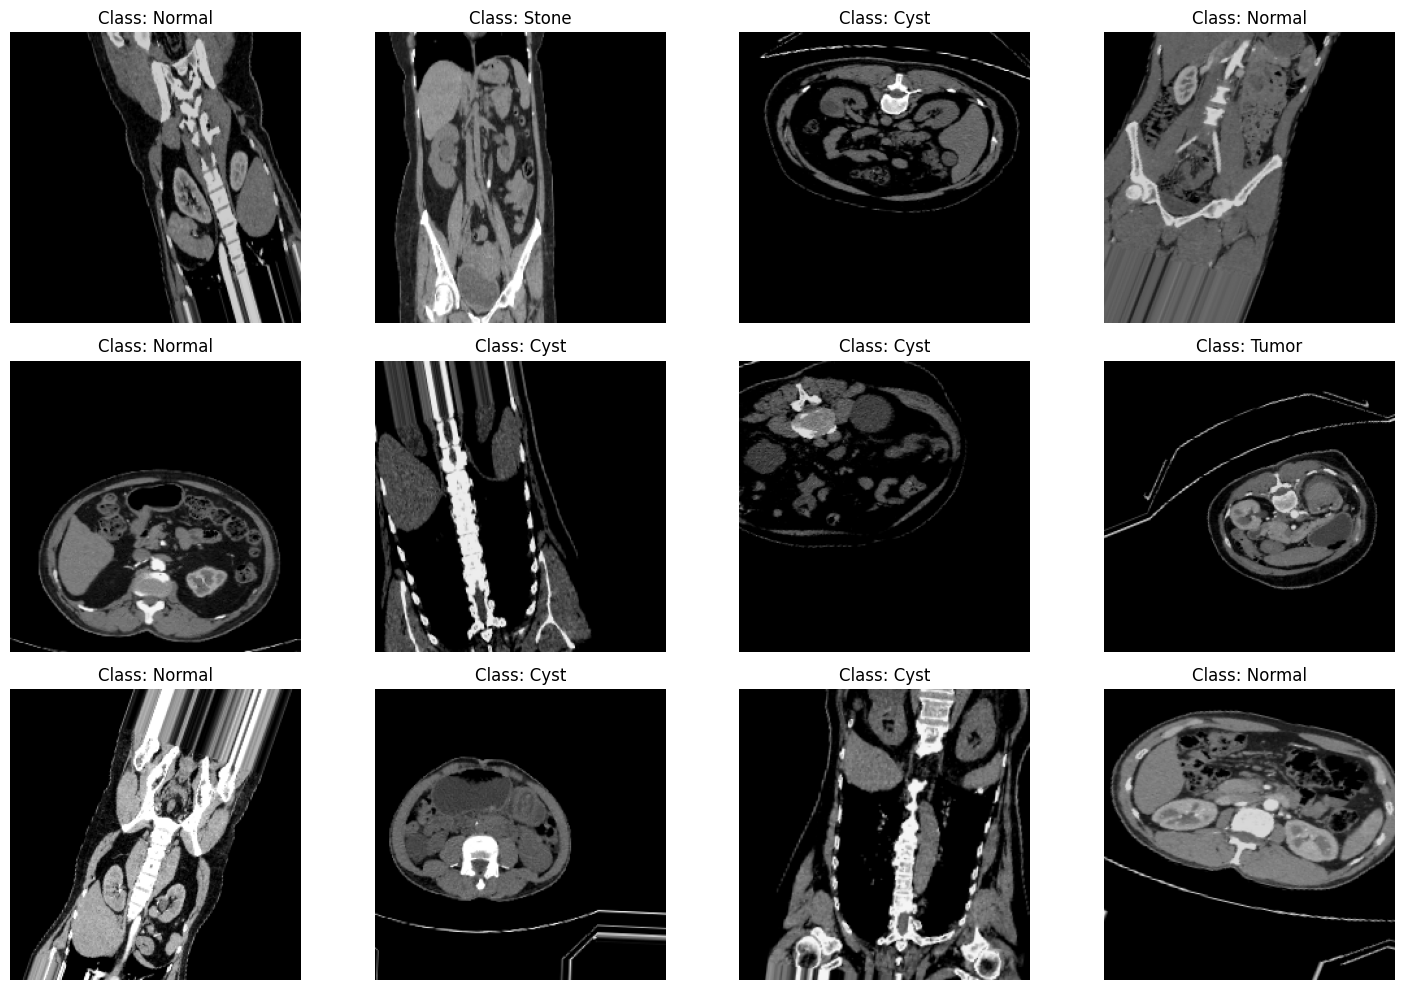

In [3]:
# 4. CALCULATE CLASS WEIGHTS
# ===============================
# Get class names from the generator
class_names = list(train_generator.class_indices.keys())
class_weights_values = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights_values))
print("Class weights:", class_weights)

# ===============================
# 5. VISUALIZE SAMPLE IMAGES
# ===============================
def plot_sample_images():
    plt.figure(figsize=(15, 10))
    sample_batch = next(train_generator)
    images, labels = sample_batch
    
    for i in range(min(12, len(images))):  # Handle small batches
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        
        class_idx = np.argmax(labels[i])
        class_names = list(train_generator.class_indices.keys())
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

In [4]:
# 6. BUILD VGG16 MODEL
# ===============================
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

I0000 00:00:1758642443.829056      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758642443.829753      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# 7. COMPILE MODEL
# ===============================
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===============================
# 8. KAGGLE-FRIENDLY CALLBACKS
# ===============================
# Save to Kaggle working directory (automatically saved as output)
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_kidney_model.h5',  # Saves to /kaggle/working/ automatically
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]
# 9. TRAIN THE MODEL (STAGE 1)
# ===============================
print("Starting Stage 1 training (frozen base)...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=12,  # First stage epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ===============================
# 10. FINE-TUNING (STAGE 2)
# ===============================
print("\nStarting Stage 2 training (fine-tuning)...")

base_model.trainable = True

# Fine-tune from layer 15 onwards
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 13
total_epochs = len(history.history['loss']) + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=len(history.history['loss']),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 7,475,972 (28.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

Starting Stage 1 training (frozen base)...
Epoch 1/12
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8275 - loss: 0.9212
Epoch 1: val_accuracy improved from -inf to 0.81935, saving model to best_kidney_model.h5
622/622 ━━━━━━━━━━━━━━━━━━━━ 181s 281ms/step - accuracy: 0.8276 - loss: 0.9211 - val_accuracy: 0.8194 - val_loss: 1.1116 - learning_rate: 1.0000e-04
Epoch 2/12
  1/622 ━━━━━━━━━━━━━━━━━━━━ 1:10 114ms/step - accuracy: 0.8750 - loss: 0.7800
Epoch 2: val_accuracy improved from 0.81935 to 0.82419, saving model to best_kidney_model.h5
622/622 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.8750 - loss: 0.7800 - val_accuracy: 0.8242 - val_loss: 1.1455 - learning_rate: 1.0000e-04
Epoch 3/12
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9068 - loss: 0.6700
Epoch 3: val_accuracy did not improve from 0.82419
622/622 ━━━━━━━━━━━━━━━━━━━━ 166s 267ms/step - accuracy: 0.9068 - loss: 0.6699 - val_accuracy: 0.8008 - val_loss: 1.2131 - learning_rate: 1.0000e-04
Epoch 4/12
 

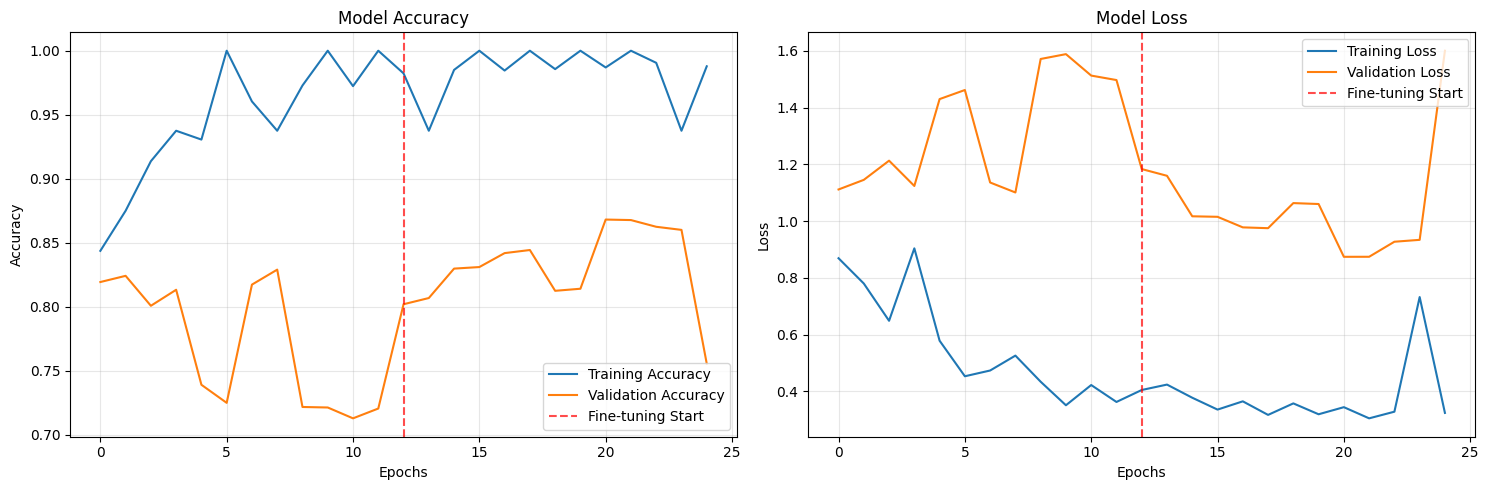

156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.83      0.86      0.85       741
      Normal       0.98      0.93      0.95      1015
       Stone       0.70      0.87      0.78       275
       Tumor       0.83      0.73      0.78       456

    accuracy                           0.87      2487
   macro avg       0.83      0.85      0.84      2487
weighted avg       0.87      0.87      0.87      2487



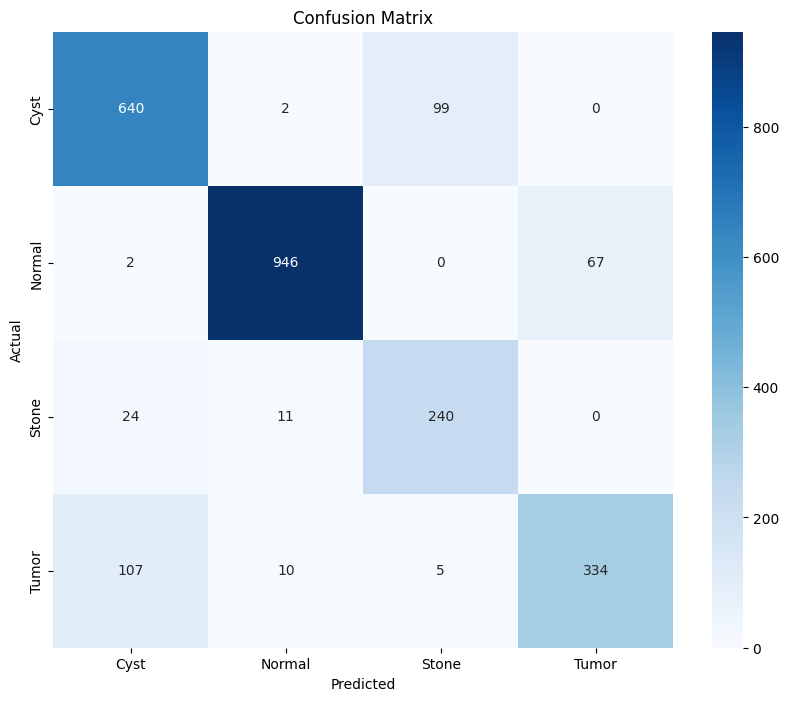


Per-class Performance:
Cyst: 0.864 (86.4%)
Normal: 0.932 (93.2%)
Stone: 0.873 (87.3%)
Tumor: 0.732 (73.2%)
Model saved to /kaggle/working/kidney_classification_model.h5

FINAL MODEL PERFORMANCE
Validation Loss: 0.8726
Validation Accuracy: 0.8685 (86.85%)

Kaggle notebook completed successfully!
Model and outputs are saved in /kaggle/working/ and will be available as dataset outputs.


In [8]:
# 11. PLOT TRAINING HISTORY
# ===============================
def plot_training_history(history, history_fine=None):
    plt.figure(figsize=(15, 5))
    
    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
        fine_tune_start = len(history.history['loss'])
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        fine_tune_start = None
    
    epochs_range = range(len(acc))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    if fine_tune_start:
        plt.axvline(x=fine_tune_start, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    if fine_tune_start:
        plt.axvline(x=fine_tune_start, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_fine)

# ===============================
# 12. COMPREHENSIVE EVALUATION
# ===============================
# Load best model
model.load_weights('best_kidney_model.h5')

# Evaluate on validation set
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
def plot_confusion_matrix(true_classes, predicted_classes, class_labels):
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Calculate per-class accuracy
    print("\nPer-class Performance:")
    for i, class_name in enumerate(class_labels):
        class_accuracy = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
        print(f"{class_name}: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")

plot_confusion_matrix(true_classes, predicted_classes, class_labels)

# ===============================
# 13. PREDICTION FUNCTION
# ===============================
def predict_image(image_path, model, class_labels):
    """Make prediction on a single image"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0
    
    prediction = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = ['red' if i == predicted_class_idx else 'lightblue' for i in range(len(class_labels))]
    plt.bar(class_labels, prediction[0], color=colors)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.3f}')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence

# ===============================
# 14. SAVE MODEL (KAGGLE OUTPUT)
# ===============================
# Save model - will be available as output
model.save('kidney_classification_model.h5')
print("Model saved to /kaggle/working/kidney_classification_model.h5")

# ===============================
# 15. FINAL PERFORMANCE SUMMARY
# ===============================
final_loss, final_accuracy = model.evaluate(validation_generator, verbose=0)

print(f"\n{'='*50}")
print(f"FINAL MODEL PERFORMANCE")
print(f"{'='*50}")
print(f"Validation Loss: {final_loss:.4f}")
print(f"Validation Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"{'='*50}")

print("\nKaggle notebook completed successfully!")
print("Model and outputs are saved in /kaggle/working/ and will be available as dataset outputs.")